In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.classical import expr   # allows classical logic on mid circuit measurement
def get_ghz_circ_dynamic(num_qubit):   
    if num_qubit%2==1:                                                  # For odd number of qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int(num_qubit/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)

    else:                                                               # For even number of Qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int((num_qubit-1)/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc


In [2]:
def get_ghz_circ_static(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc
    
    

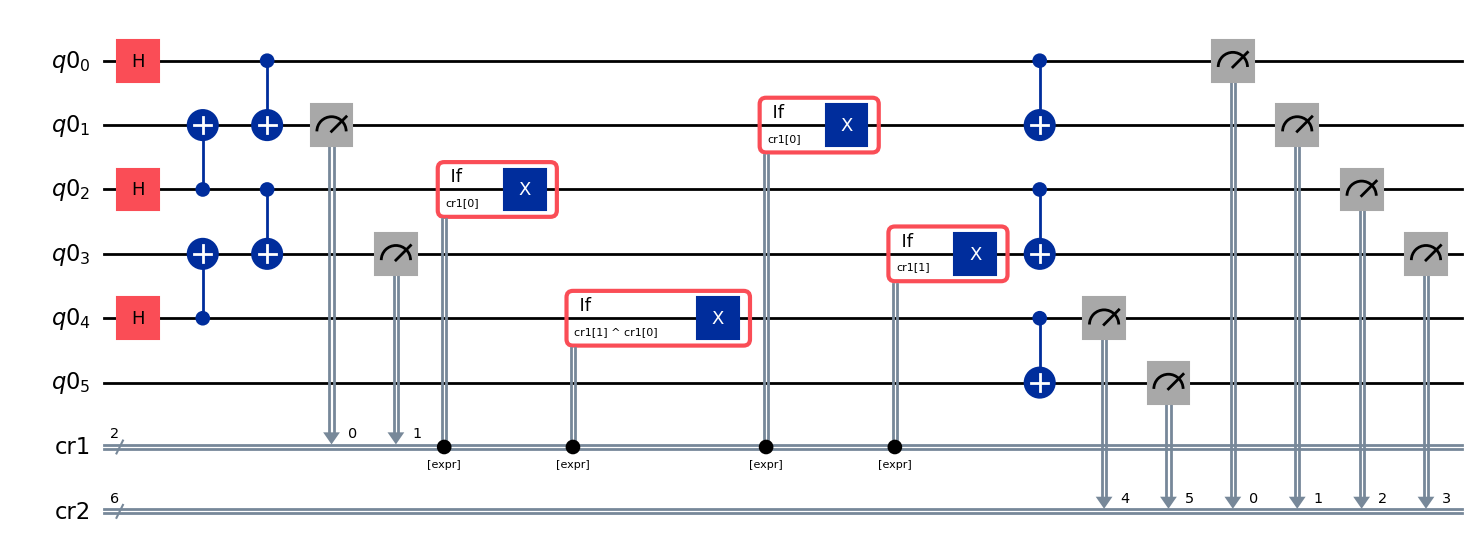

In [3]:
qc = get_ghz_circ_dynamic(num_qubit=6)
qc.draw("mpl")

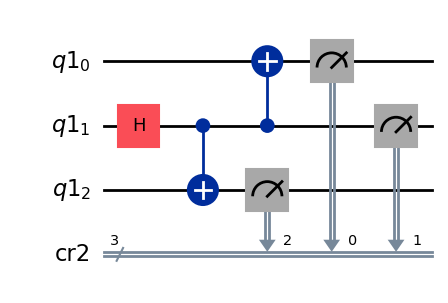

In [4]:
qc = get_ghz_circ_static(num_qubit=3)
qc.draw("mpl")

In [10]:
#Creating list of circuits [Static1, Dynamic1, Static1, Dyanmic1,...,static2,dynamic2,staic2,dynamic2,...] i.e. some copies of each of them
min_qubit=3
max_num_qubit=12
copies=4
#qc_list_dynamic=[]
#qc_list_static=[]
#observables=[]
qc_list=[]
num_qubit_list=[]
for i in range(min_qubit,max_num_qubit+1):
    num_qubit_list.append(i)

for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_ghz_circ_static(num_qubit))
        qc_list.append(get_ghz_circ_dynamic(num_qubit))

In [11]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
qc_transpiled_list=[]



qc_transpiled_list_ideal = pm.run(qc_list)



In [12]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [13]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_ideal[(2*i*copies)+(2*j)].data
        data_dynamic = result_ideal[(2*i*copies)+((2*j)+1)].data
        counts_static=data_static.cr2.get_counts()
        counts_dynamic=data_dynamic.cr2.get_counts()
        counts_list_ideal.append(counts_static)
        counts_list_ideal.append(counts_dynamic)

In [14]:
#genericBackendV2
# trasnpilation
from qiskit.providers.fake_provider import GenericBackendV2
backend = GenericBackendV2(num_qubits=max_num_qubit,control_flow=True,seed=2)     # fixed seed for reproducibility, num_qubits at least should be 2

qc_transpiled_list_GenBackendV2 = transpile(qc_list, backend)


In [15]:
# Run the transpiled circuits using the simulated backend and post pocessing
job = backend.run(qc_transpiled_list_GenBackendV2)
result_GenBackendV2=job.result()


In [16]:
print(result_GenBackendV2)

Result(backend_name='aer_simulator', backend_version='0.13.3', qobj_id='', job_id='4a26646c-852d-4870-9f83-e82e95087a81', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 503, '0x7': 511, '0x3': 1, '0x4': 2, '0x5': 5, '0x2': 1, '0x6': 1}), header=QobjExperimentHeader(creg_sizes=[['cr2', 3]], global_phase=0.7853981633974483, memory_slots=3, n_qubits=12, name='circuit-1008', qreg_sizes=[['q', 12]], metadata={}), status=DONE, seed_simulator=1828868171, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'density_matrix', 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 3, 'num_clbits': 17, 'time_taken': 0.0034835, 'sample_measure_time': 0.0003525, 'input_qubit_map': [[0, 0], [1, 1], [2, 2]], 'max_memory_mb': 16024, 'measure_sampling': True, 'noise': 'superop', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_

In [17]:
#get list counts_list_GenBackendV2 (argument required for Fidelity)
counts_list_GenBackendV2=result_GenBackendV2.get_counts()

In [13]:
#testing cell
from qiskit.result import marginal_counts
cr2_result=marginal_counts(counts_list_GenBackendV2[1],[1,2,3])
cr3_result=marginal_counts(counts_list_GenBackendV2[5],[1,2,3,4])
print("h",cr2_result)
print("h",cr3_result)



h {'100': 9, '000': 500, '111': 501, '001': 3, '101': 4, '110': 5, '011': 2}
h {'1100': 4, '0000': 505, '1111': 491, '0111': 4, '1101': 5, '1011': 7, '0011': 3, '0001': 2, '1110': 3}


In [18]:
print(counts_list_GenBackendV2)
print(len(counts_list_GenBackendV2))

[{'000': 503, '111': 511, '011': 1, '100': 2, '101': 5, '010': 1, '110': 1}, {'111 0': 246, '111 1': 246, '000 0': 264, '000 1': 245, '101 1': 1, '001 0': 3, '110 0': 4, '110 1': 3, '100 1': 2, '100 0': 3, '101 0': 4, '010 1': 1, '001 1': 1, '011 0': 1}, {'111': 498, '110': 8, '000': 503, '010': 6, '101': 7, '100': 2}, {'101 0': 3, '000 1': 241, '011 0': 4, '111 1': 256, '010 1': 1, '111 0': 236, '000 0': 268, '110 1': 4, '100 1': 4, '001 0': 3, '011 1': 2, '100 0': 2}, {'000': 487, '111': 518, '110': 8, '001': 3, '101': 3, '011': 2, '010': 2, '100': 1}, {'010 1': 6, '111 0': 263, '100 0': 4, '000 0': 243, '000 1': 245, '111 1': 251, '101 1': 3, '110 0': 2, '110 1': 3, '001 1': 1, '101 0': 1, '100 1': 1, '010 0': 1}, {'111': 486, '000': 525, '010': 4, '101': 6, '110': 2, '100': 1}, {'100 0': 10, '000 0': 238, '000 1': 259, '011 0': 1, '111 1': 254, '111 0': 240, '011 1': 5, '001 0': 3, '101 1': 3, '110 1': 3, '100 1': 2, '010 1': 4, '101 0': 1, '010 0': 1}, {'1000': 1, '0000': 481, '11

In [19]:
#Calculation of lists of Fidelity mean and std deviation of all 4 hardware simulation
import statistics
from qiskit.result import marginal_distribution
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
# For GHZ state analysis: index 0 of these lists store informationn of GHZ state having 3 qubits, index 1 for 4 qubits and so on 
Fidelity_mean_static_GenBackendV2=[]
Fidelity_mean_dynamic_GenBackendV2=[]
Fidelity_std_static_GenBackendV2=[]
Fidelity_std_dynamic_GenBackendV2=[]
Fidelity_copies_static_GenBackendV2=[]                  # last these 2 lists are required for intermediate steps
Fidelity_copies_dynamic_GenBackendV2=[]
list=[]
print(num_qubit_list)

for i in range(0,len(num_qubit_list)):
    num_qubit = num_qubit_list[i]
    print(num_qubit)

    if num_qubit % 2 == 1:                            # For odd number of qubits   
        x=int(num_qubit/2)     
    else:
        x=int((num_qubit-1)/2)
    print("x is",x)
    for k in range(x,x+num_qubit):
        list.append(k)
    
    for j in range(copies):
        Fidelity_static= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_GenBackendV2[(2*i*copies)+(2*j)])   # static dynamic are 2
        print("dynamic circuit index",((2*i*copies)+((2*j)+1)))
        z=counts_list_GenBackendV2[(2*i*copies)+((2*j)+1)]
        print("hello",list)                                                                       # For finding errors
        y = marginal_distribution(z,list)
        print("hello",list)                                                                        # For finding errors
        Fidelity_dynamic=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], y )
        Fidelity_copies_static_GenBackendV2.append(Fidelity_static)
        Fidelity_copies_dynamic_GenBackendV2.append(Fidelity_dynamic)

    

    
    Fidelity_mean_static_GenBackendV2.append(statistics.mean(Fidelity_copies_static_GenBackendV2))
    Fidelity_mean_dynamic_GenBackendV2.append(statistics.mean(Fidelity_copies_dynamic_GenBackendV2))
    Fidelity_std_static_GenBackendV2.append(statistics.stdev(Fidelity_copies_static_GenBackendV2))
    Fidelity_std_dynamic_GenBackendV2.append(statistics.stdev(Fidelity_copies_dynamic_GenBackendV2))
    Fidelity_copies_static_GenBackendV2.clear()
    Fidelity_copies_dynamic_GenBackendV2.clear()
    list.clear()
    print(" A single inside_loop is finished")

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
3
x is 1
dynamic circuit index 1
hello [1, 2, 3]
hello [1, 2, 3]
dynamic circuit index 3
hello [1, 2, 3]
hello [1, 2, 3]
dynamic circuit index 5
hello [1, 2, 3]
hello [1, 2, 3]
dynamic circuit index 7
hello [1, 2, 3]
hello [1, 2, 3]
 A single inside_loop is finished
4
x is 1
dynamic circuit index 9
hello [1, 2, 3, 4]
hello [1, 2, 3, 4]
dynamic circuit index 11
hello [1, 2, 3, 4]
hello [1, 2, 3, 4]
dynamic circuit index 13
hello [1, 2, 3, 4]
hello [1, 2, 3, 4]
dynamic circuit index 15
hello [1, 2, 3, 4]
hello [1, 2, 3, 4]
 A single inside_loop is finished
5
x is 2
dynamic circuit index 17
hello [2, 3, 4, 5, 6]
hello [2, 3, 4, 5, 6]
dynamic circuit index 19
hello [2, 3, 4, 5, 6]
hello [2, 3, 4, 5, 6]
dynamic circuit index 21
hello [2, 3, 4, 5, 6]
hello [2, 3, 4, 5, 6]
dynamic circuit index 23
hello [2, 3, 4, 5, 6]
hello [2, 3, 4, 5, 6]
 A single inside_loop is finished
6
x is 2
dynamic circuit index 25
hello [2, 3, 4, 5, 6, 7]
hello [2, 3, 4, 5, 6, 7]
dy

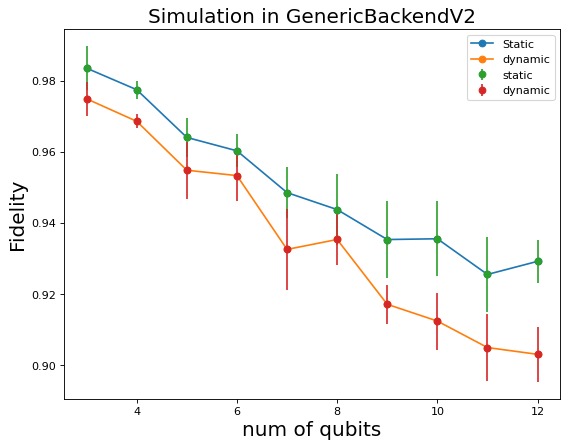

In [20]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=80)

plt.xlabel('num of qubits',fontsize=18)
plt.ylabel('Fidelity',fontsize=18)
plt.title('Simulation in GenericBackendV2',fontsize=18)
x = num_qubit_list
y_static = Fidelity_mean_static_GenBackendV2
y_dynamic = Fidelity_mean_dynamic_GenBackendV2
y_error_static =Fidelity_std_static_GenBackendV2
y_error_dynamic =Fidelity_std_dynamic_GenBackendV2
plt.plot(x, y_static, 'o-',label='Static')
plt.plot(x, y_dynamic, 'o-',label='dynamic')
plt.errorbar(x, y_static,
			yerr = y_error_static, label='static',
			fmt ='o')
plt.errorbar(x, y_dynamic,
			yerr = y_error_dynamic, label='dynamic',
			fmt ='o')

plt.legend()
plt.show()